<h1>Kaggle Lending Club</h1>
<h2>Analyse exploratoire</h2>
<h3>1 - Description des variables</h3>
<ol>
   <li>Variables liées au crédit : <br/>
      <b>loan_amnt</b>	      The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.<br/>
      <b>funded_amnt</b>	      The total amount committed to that loan at that point in time.<br/>
      <b>funded_amnt_inv</b>	  The total amount committed by investors for that loan at that point in time.<br/>
      <b>term</b>               The number of payments on the loan. Values are in months and can be either 36 or 60.<br/>
      <b>int_rate</b>	          Interest Rate on the loan<br/>
      <b>installment</b>	      The monthly payment owed by the borrower if the loan originates.<br/>
      <b>grade</b>	          LC assigned loan grade<br/>
      <b>sub_grade</b>	      LC assigned loan subgrade<br/>
      <b>issue_d</b>	The month which the loan was funded
      <b>loan_status</b>	Current status of the loan
      <b>pymnt_plan</b>	Indicates if a payment plan has been put in place for the loan
      <b>purpose</b>	A category provided by the borrower for the loan request. 
      <b>initial_list_status</b>	The initial listing status of the loan. Possible values are – W, F
      <b>last_pymnt_d</b>	Last month payment was received
   </li>
   <li> Variables liées à l'emprunteur  : <br/>
      <b>emp_title</b>	The job title supplied by the Borrower when applying for the loan.<br/>
      <b>emp_length</b>	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. <br/>
      <b>home_ownership</b>	The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.<br/>
      <b>annual_inc</b>	The self-reported annual income provided by the borrower during registration.<br/>
      <b>verification_status</b>	Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified<br/>
   <b>zip_code</b>	The first 3 numbers of the zip code provided by the borrower in the loan application.<br/>
   <b>addr_state</b>	The state provided by the borrower in the loan application<br/>
   </li>
   <li> Variables liées à l'emprunteur  : <br/>
      <b>dti</b>	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.<br/>
      <b>delinq_2yrs</b>	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years<br/>
      <b>earliest_cr_line</b>	The month the borrower's earliest reported credit line was opened<br/>
      <b>inq_last_6mths</b>	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)<br/>
      <b>mths_since_last_delinq</b>	The number of months since the borrower's last delinquency.<br/>
      <b>mths_since_last_record</b>	The number of months since the last public record.<br/>
      <b>open_acc</b>	The number of open credit lines in the borrower's credit file.<br/>
      <b>pub_rec</b>	Number of derogatory public records<br/>
   </li>
</ol>

Chargement des données :

In [1]:


import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Configuration
pd.options.display.max_columns=100
%matplotlib inline

#Load and format data
data = pd.read_csv('../inputs/loan.csv', low_memory=False,
                   dtype={'term':np.str},
                   parse_dates=['last_pymnt_d','issue_d', 'term']
                  )

data.drop(['url', 'desc', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'verification_status','revol_bal', 'revol_util', 'initial_list_status',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type' ], axis=1, inplace=True);
data=data.dropna(axis=1, how='all')

In [2]:
data['annual_inc'].dtypes

dtype('float64')

<h3>2 - Compréhension des variables</h3>
<br/>

Peut-on amalgamer funded_amnt_inv et loan_amnt ?<br/>
Oui. Différence relative entre la somme cumulée des deux variables :

In [3]:
(data['loan_amnt'].sum()-data['funded_amnt_inv'].sum())/data['loan_amnt'].sum()*100

0.3578398847682243

<h3>3 - Prêts : </h3>

In [4]:
data['last_pymnt_y']=data['last_pymnt_d'].apply(lambda x: x.year)
data['last_pymnt_d'].max()
data['term'] = data['term'].apply(lambda x: x[0:3])
data['term'] = pd.to_numeric(data['term'])
data['effective_term'] = data['last_pymnt_d'] - data['issue_d']
data['pymnt_duration'] = ((data['effective_term'] / np.timedelta64(1, 'M')).round())
data['pymnt_delay']=data['pymnt_duration']-data['term']

In [5]:
data['issue_y']=data['issue_d'].apply(lambda x: x.year)

Evolution exponentielle du volume des emprunts émis :

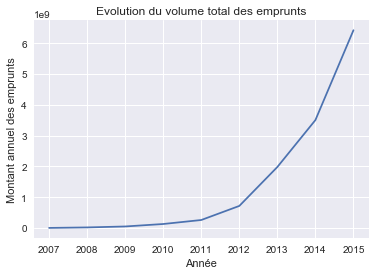

In [6]:
total_loan = pd.Series(data.groupby('issue_y')['loan_amnt'].sum())
plt.plot(total_loan)
plt.title('Evolution du volume total des emprunts')
plt.xlabel('Année')
plt.ylabel('Montant annuel des emprunts')
plt.show()

Détaillons par statut de l'emprunt :

In [7]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'], dtype=object)

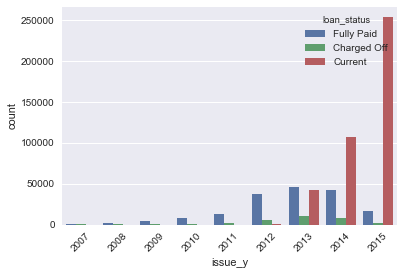

In [8]:
term2display = 36
data2disp=data[(data['term']==term2display) & (data['loan_status'].isin(['Current','Fully Paid', 'Charged Off']))]
plt2 = sns.countplot(x="issue_y", data=data2disp, hue='loan_status', orient='h')
plt2.set_xticklabels(labels=plt2.get_xticklabels(), rotation=45);

In [9]:
#plt2 = sns.countplot(x="issue_y", data=data, hue='term', orient='h')
#plt2.set_xticklabels(labels=plt2.get_xticklabels(), rotation=45);

In [10]:
data['last_pymnt_d'].max()

Timestamp('2016-01-01 00:00:00')

Graph précédent = combinaison de 2 phénomènes.
Premièrement, augmentation globale de l émission de crédit (croissance naturelle de la plateforme LC)
Deuxièment, pour les crédits sur 3 ans, augmentation des Current sur ces trois dernières années

On filtre sur la base sur les dates qui permettent au loan d'arriver à terme :

In [11]:
valid_data = data[  ( (data['loan_status'].isin(['Fully Paid', 'Charged Off'])) &
                ( (data['issue_d'] < np.datetime64('2012-06-01')) & (data['term']==36) ) 
                | ( (data['issue_d'] < np.datetime64('2010-06-01')) & (data['term']==60) ) ) ].copy(deep=True)

valid_data.shape

(41197, 48)

NameError: name 'b' is not defined

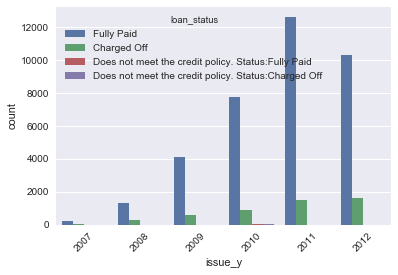

In [12]:
plt2 = sns.countplot(x="issue_y", data=valid_data, hue='loan_status', orient='h')
plt2.set_xticklabels(labels=plt2.get_xticklabels(), rotation=45);b

Remarque : sur ce dernier graphe : 2012 => le count se fait sur 6 mois seulement

<h3>4 - Emprunteurs</h3>
<br/>
Evaluation des emprunteurs par le délai de paiement sur leur loan (en mois) => pymnt_delay.<br/>

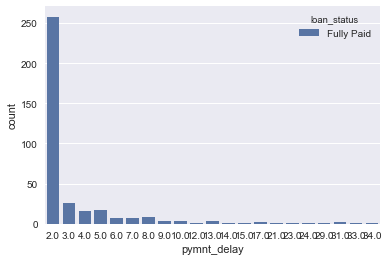

In [13]:
data_delay = valid_data[(valid_data['pymnt_delay']>=2) & (valid_data['loan_status'].isin(['Fully Paid']))]
sns.countplot(x='pymnt_delay', data=data_delay, hue='loan_status', orient='h')
plt.figure()

In [ ]:
dataviz['annual_inc'].quantile(0.9)

Corrélation de ce délai avec les données sur le users :

In [ ]:
valid_data.groupby('zip_code').mean()['pymnt_delay']

In [ ]:
plt.figure()
dataviz = valid_data[['pymnt_delay', 'annual_inc']]
dataviz = dataviz[ dataviz['annual_inc'] < dataviz['annual_inc'].quantile(0.9) ]
dataviz['pymnt_delay']

sns.jointplot(x='annual_inc', y='pymnt_delay', data=dataviz, joint_kws={'alpha':0.008})
plt.show()

valid_data.groupby('home_ownership').sum()
sns.countplot(x="pymnt_delay", data=valid_data, hue='home_ownership', orient='h')
plt2.set_xticklabels(labels=plt2.get_xticklabels(), rotation=45);b

In [ ]:
valid_data['gain']=valid_data['total_pymnt']-valid_data['loan_amnt']
valid_data['relative_gain']=valid_data['gain']/valid_data['loan_amnt']*100

In [ ]:
sns.jointplot(x='pymnt_delay', y='relative_gain', data=valid_data, joint_kws={'alpha':0.08})
plt.show()

sns.jointplot(x='pymnt_delay', y='relative_gain', data=valid_data, joint_kws={'alpha':0.08}, xlim={0,5}, ylim={0,40})
plt.show()

plt.figure()
data2 = valid_data[valid_data['pymnt_delay']>=0]
data2.boxplot(column='relative_gain', by='pymnt_delay')
data2.boxplot(column='relative_gain', by='pymnt_delay')
plt.show()

In [ ]:
data2.size
data2[data2['pymnt_delay']==4].size

In [ ]:
#Quel est le retour sur investissement de chaque prêt? Total/Annuel/Mensuel
plt.figure()
valid_data.boxplot(column='relative_gain', by='grade')
plt.show()

In [ ]:
plt.figure()
plt1 = sns.countplot(x="loan_status", data=valid_data)
plt1.set_xticklabels(labels=plt1.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
T=valid_data['pymnt_duration']
G=valid_data['relative_gain']
I=valid_data['loan_amnt']
NAR = (np.power(np.abs((G/100+1)),12/T)-1) * ((G>0)-0.5)*2*100
NAR=NAR.replace([np.inf, -np.inf], 0)
valid_data['NAR']=NAR
valid_data['NAR'].mean()

In [ ]:
valid_data['int_rate'].mean()

In [ ]:
plt.figure()
valid_data.boxplot(column='int_rate', by='grade')
plt.show()

In [ ]:
plt.figure()
valid_data.boxplot(column='NAR', by='grade', showfliers=False)
plt.show()

In [ ]:
valid_data

In [ ]:
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])

In [ ]:
sns.jointplot(x=valid_data['loan_amnt'], y=valid_data['annual_inc'], kind="hex", color="k",ylim=[0,100000])
plt.show()